In [2]:
from IPython.display import clear_output
!pip install tensorflow==2.7.0
clear_output()

In [ ]:
import numpy as np 
import sympy as sp
import pandas as pd
import tensorflow as tf
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize
from tensorflow.python.eager.backprop import GradientTape
from PIL import Image
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
import glob
import imageio
from IPython import display

from h5py import File as HDF5File
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
electron_datafile = '/content/gdrive/MyDrive//electron.hdf5'
photon_datafile = '/content/gdrive/MyDrive//photon.hdf5'

In [ ]:
electron_data = HDF5File(electron_datafile, 'r')
photon_data = HDF5File(photon_datafile, 'r')

In [ ]:
X_e, y_e = electron_data['X'], electron_data['y']
X_e_0 = X_e[:,:,:,0]
X_e_1 = X_e[:,:,:,1]
print(X_e_0.shape)

(249000, 32, 32)


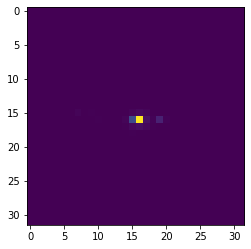

In [ ]:
plt.imshow(X_e_0[0,:,:])

In [ ]:
X_p, y_p = photon_data['X'], photon_data['y']
X_p_0 = X_p[:,:,:,0]
X_p_1 = X_p[:,:,:,1]
print(X_p_0.shape)
print(y_p.shape)

(249000, 32, 32)
(249000,)


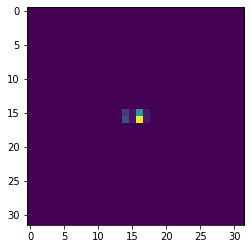

In [ ]:
plt.imshow(X_p_0[0,:,:])

In [ ]:
center = [int(528/32), 528%32]

img_size = 8
X_e_0 = X_e_0[:, (center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]
X_p_0 = X_p_0[:, (center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]

print(X_e_0.shape,X_p_0.shape)

(249000, 8, 8) (249000, 8, 8)


In [ ]:
z = np.random.normal(size=X_e_0.shape)
print(z.shape)

(249000, 8, 8)


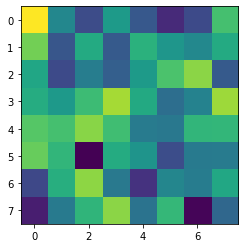

In [ ]:
plt.imshow(z[0])

In [ ]:
def FID(model,images_1,images_2):
  images_1 = preprocess_input(images_1)
  images_2 = preprocess_input(images_2)
  
  act1 = model.predict(images_1)
  act2 = model.predict(images_2)
  mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
  ssdiff = np.sum((mu1-mu2)**2)
  covmean = sqrtm(sigma1.dot(sigma2))
  if iscomplexobj(covmean):
    covmean =covmean.real
  
  fid = ssdiff + trace(sigma1 + sigma2 - 2.0*covmean)
  return fid

In [ ]:
def scale_images(images,size):
  images_list = []
  for image in images:
    new_image = resize(image,size,0)
    images_list.append(new_image)
  return asarray(images_list)

In [ ]:
inc_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
new_images_e = scale_images(X_e_0[:500],(299,299,3))
new_images_p = scale_images(X_p_0[:500],(299,299,3))
new_images_z = scale_images(z[:500],(299,299,3))
FID(inc_model,new_images_e,new_images_p)

In [ ]:
def create_classical_generator():
    model = tf.keras.Sequential()
    # foundation for 2x2 image
    n_nodes = 64 * 2 * 2
    model.add(tf.keras.layers.Dense(n_nodes, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((2, 2, 64)))

    model.add(tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(1,1), padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    # model.add(tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(1,1), padding="same", use_bias=False))
    # model.add(tf.keras.layers.BatchNormalization())
    # model.add(tf.keras.layers.LeakyReLU())
    
    # upsample to 4x4
    model.add(tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())    
    # upsample to 8x8
    model.add(tf.keras.layers.Conv2DTranspose(1, (3,3), strides=(2,2), padding="same", use_bias=False, activation='tanh'))
    return model

def create_classical_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[8, 8, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (2, 2), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(64, (2, 2), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
# def train_qgan(real_data,):
generator_model = create_classical_generator()
discriminator_model = create_classical_discriminator()

In [ ]:
generator_model.summary()
discriminator_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25600     
                                                                 
 batch_normalization_94 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 2, 2, 32)         8192      
 nspose)                                                         
                                                                 
 batch_normalization_95 (Bat  (None, 2, 2, 32)         1

In [ ]:
class QGAN():
  def __init__(self,discriminator,generator,disc_optimizer,gen_optimizer):
    self.generator_model = generator
    self.discriminator_model = discriminator
    self.d_opt = disc_optimizer
    self.g_opt = gen_optimizer
    # self.g_lr = gen_learning_rate
    # self.d_lr = disc_learning_rate
    self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    self.gen_loss_ = []
    self.disc_loss_ = []
    self.epochs_ = []
    # self.d_opt = self.d_opt(self.d_lr)
    # self.g_opt = self.g_opt(self.g_lr)

  def prepare_dataset(self,data,batch_size,seed=None,drop_remainder=True,buffer_size=100):
    buffer_size =len(data[0])
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.shuffle(buffer_size=buffer_size,seed=seed,reshuffle_each_iteration=True)
    ds = ds.batch(batch_size,drop_remainder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

  def train_preprocess(self,random_state):
    tf.random.set_seed(random_state)
    np.random.seed(random_state)
  
  @tf.function
  def generator_loss(self,fake_output):
    # return self.loss(tf.ones_like(fake_output),fake_output)
    return -self.loss(tf.zeros_like(fake_output),fake_output)

  @tf.function
  def discriminator_loss(self,real_output,fake_output):
    real_loss = self.loss(tf.ones_like(real_output),real_output)
    fake_loss = self.loss(tf.zeros_like(fake_output),fake_output)
    return real_loss + fake_loss
  
  @tf.function
  def train_step_1v1(self,x_real,batch_size):
    """Training step for one epoch with 1 generator step and 1 discriminator step
        """
    fake_data_shape = (batch_size,) + self.generator_model.input_shape[1:]
    z = tf.random.normal(shape=fake_data_shape)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      x_fake_ = self.generator_model(z, training=True)
      real_output = self.discriminator_model(x_real, training=True)
      fake_output = self.discriminator_model(x_fake_, training=True)
      gen_loss = self.generator_loss(fake_output)
      disc_loss = self.discriminator_loss(real_output, fake_output)
    grad_gen = gen_tape.gradient(gen_loss, self.generator_model.trainable_variables)
    grad_disc = disc_tape.gradient(disc_loss, self.discriminator_model.trainable_variables)
    self.g_opt.apply_gradients(zip(grad_gen, self.generator_model.trainable_variables))
    self.d_opt.apply_gradients(zip(grad_disc, self.discriminator_model.trainable_variables))  
    return gen_loss, disc_loss

  @tf.function
  def train_step_nv1(self,x_real,n_disc,batch_size):
    for i in range(n_disc):
      x_real_batch = tf.gather(x_real,i)
      d_loss = self.discriminator_step(x_real_batch,batch_size)
    g_loss = self.generator_step(batch_size)
    return g_loss, d_loss

  @tf.function
  def train_step_1vn(self,x_real,n_gen,batch_size):
    for i in range(n_gen):
      g_loss = self.generator_step(batch_size)
    d_loss = self.discriminator_step(x_real,batch_size)
    return g_loss, d_loss 

  @tf.function
  def discriminator_step(self,x_real,batch_size):
    fake_data_shape = (batch_size,) + self.generator_model.input_shape[1:]
    z = tf.random.normal(shape=fake_data_shape)
    with tf.GradientTape() as gradient_tape:
      real_output = self.discriminator_model(x_real,training = True)
      fake_input = self.generator_model(z, training = True) 
      fake_output = self.discriminator_model(fake_input,training = True)
      cost = self.discriminator_loss(real_output,fake_output)
    grad = gradient_tape.gradient(cost,self.discriminator_model.trainable_variables)
    self.d_opt.apply_gradients(zip(grad,self.discriminator_model.trainable_variables))
    return cost

  @tf.function
  def generator_step(self,batch_size):
    fake_data_shape = (batch_size,) + self.generator_model.input_shape[1:]
    z = tf.random.normal(shape=fake_data_shape)
    with tf.GradientTape() as gradient_tape:
      fake_input = self.generator_model(z,training=True)
      fake_output = self.discriminator_model(fake_input,training= True) #
      loss = self.generator_loss(fake_output)
    grad = gradient_tape.gradient(loss,self.generator_model.trainable_variables)
    self.g_opt.apply_gradients(zip(grad,self.generator_model.trainable_variables))
    return loss
  
  def train_qgans(self,x,epochs,batch_size,seed=1024,n_disc=1,n_gen=1):
    input_shape = x.shape[1:]
    self.train_preprocess(seed)
    data = self.prepare_dataset(data=x,batch_size=batch_size*n_disc,seed=seed)
    g_metric = tf.keras.metrics.Mean()
    d_metric = tf.keras.metrics.Mean()
    for epoch in range(epochs):
      for step,training_batch_data_ in enumerate(data):
        if( n_disc == 1 and n_gen == 1):
          input_batch_shape = (batch_size,) + input_shape
          training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
          gen_loss,disc_loss = self.train_step_1v1(x_real=training_batch_data, batch_size=batch_size)
          display.clear_output(wait=True)
          generate_and_save_images(self.generator_model,epoch + 1,batch_size)
        if n_disc > 1 and n_gen == 1:
          input_batch_shape = (n_disc, batch_size) + input_shape
          training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)        
          gen_loss,disc_loss = self.train_step_nv1(x_real=training_batch_data, batch_size=batch_size,n_disc=n_disc)
          display.clear_output(wait=True)
          generate_and_save_images(self.generator_model,epoch + 1,batch_size)
        if n_gen > 1 and n_disc == 1:
          input_batch_shape = (batch_size,) + input_shape
          training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
          gen_loss,disc_loss = self.train_step_1vn(x_real=training_batch_data, batch_size=batch_size,n_gen=n_gen)
          display.clear_output(wait=True)
          generate_and_save_images(self.generator_model,epoch + 1,batch_size)
        g_metric(gen_loss)
        d_metric(disc_loss)
      self.gen_loss_.append(g_metric.result().numpy())
      self.disc_loss_.append(d_metric.result().numpy())
      self.epochs_.append(epoch)
      print("Epoch:{} ;   generator_loss:{} ;   discriminator_loss:{}".format(epoch,g_metric.result().numpy(),d_metric.result().numpy()))
  
      g_metric.reset_state()
      d_metric.reset_state()
      display.clear_output(wait=True)
    return self.gen_loss_,self.disc_loss_,self.epochs_

  def generate_samples(self,batch_size, shape=None):
    """Generates sample using random inputs
        
            Arguments:
                batch_size: int
                    Number of samples to generate.
                shape: (Optional) tuple of int
                    Reshape the output to the given shape.
        """
    z_batch_shape = (batch_size,) + self.generator_model.input_shape[1:]
    z = tf.random.normal(z_batch_shape)
    print(z.shape[0])
    samples = self.generator_model(z,training = False)
    return samples

  def predict(self, x):
    return self.discriminator_model(x, training=False)


In [ ]:
def generate_and_save_images(model, epoch, batch_size):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  z_batch_shape = (batch_size,) + model.input_shape[1:]
  z = tf.random.normal(z_batch_shape) 
  predictions = model(z, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(4):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
fake_data_shape = (10000,) + generator_model.input_shape[1:]
print(fake_data_shape)
print(generator_model.output_shape)
print(discriminator_model.input_shape)

(10000, 100)
(None, 8, 8, 1)
(None, 8, 8, 1)


In [ ]:
def plot_jet_image(content,
#                     output_name,
                    vmin=1e-6,
                    vmax=300,
                    title=''):
    '''
    Function to help you visualize a jet image on a log scale
    Args:
    -----
       content : numpy array of dimensions 25x25, first arg to imshow, content of the image
                 e.g.: generated_images.mean(axis=0) --> the average generated image
                       real_images.mean(axis=0) --> the average Pythia image
                       generated_images[aux_out == 1].mean(axis=0) --> the average generated image labeled as real by the discriminator 
                       etc...
       output_name : string, name of the output file where the plot will be saved. Note: it will be located in ../plots/
       vmin : (default = 1e-6) float, lower bound of the pixel intensity scale before saturation
       vmax : (default = 300) float, upper bound of the pixel intensity scale before saturation
       title : (default = '') string, title of the plot, to be displayed on top of the image
    Outputs:
    --------
       no function returns
       saves file in ../plots/output_name
    '''
    fig, ax = plt.subplots(figsize=(3, 2))
    extent=[-1.25, 1.25, -1.25, 1.25]
    im = ax.imshow(content, interpolation='nearest', norm=LogNorm(vmin=vmin, vmax=vmax), extent=extent)
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $p_T$ (GeV)', y=0.85)
    plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
    plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
    plt.title(title)

In [ ]:
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model = QGAN(generator=generator_model,discriminator=discriminator_model,disc_optimizer=d_optimizer,gen_optimizer=g_optimizer)

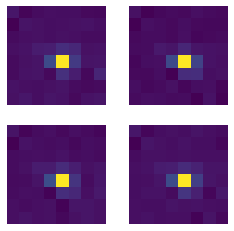

Epoch:139 ;   generator_loss:-0.6950502395629883 ;   discriminator_loss:1.387168526649475


In [ ]:
X_e_0_final = np.reshape(X_e_0, (X_e_0.shape[0], 8, 8, 1))
gen_loss_,disc_loss_,epochs_ = model.train_qgans(X_e_0_final,epochs=140,batch_size=40000,seed=2021,n_gen=10)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_loss(gen_loss,disc_loss,epochs):
  fig = plt.figure(figsize=(16,9))
  gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
  epoch = epochs[-1]
  # plot loss curve
  ax_loss = plt.subplot(gs[:,:4])
  ax_loss.set_xlim(0, 1.1*epoch)
  ax_loss.plot(epochs, gen_loss, label="Generator")
  ax_loss.plot(epochs, disc_loss, label="Discriminator")
  ax_loss.set_xlabel('Epoch', fontsize=20)
  ax_loss.set_ylabel('Loss', fontsize=20)
  ax_loss.grid(True)
  ax_loss.legend(fontsize=15)

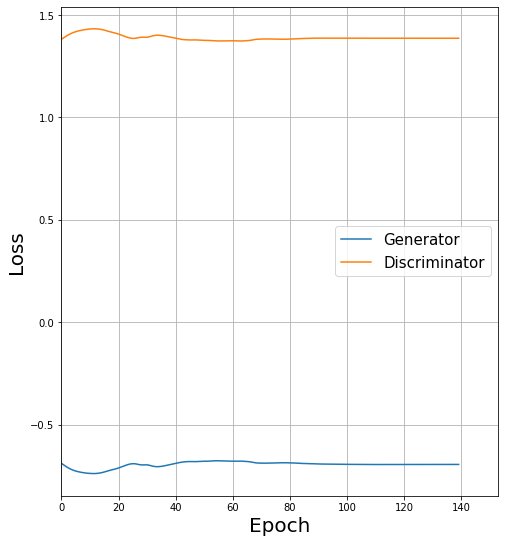

In [ ]:
plot_loss(gen_loss_,disc_loss_,epochs_)

8


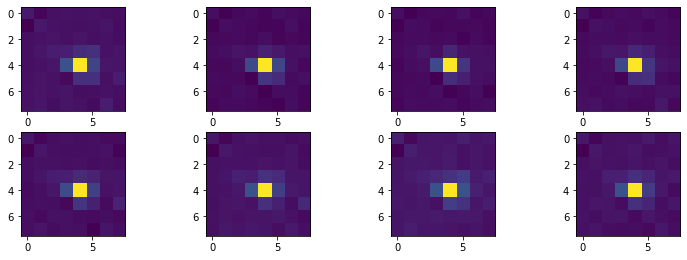

In [ ]:
n_images = 8
samples = np.reshape(np.array(model.generate_samples(batch_size=n_images,shape=(5,))),(n_images,8,8))
fig = plt.figure(figsize=(26,18))
gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
for i in range(samples.shape[0]):
  ax = plt.subplot(gs[i//4, 4 + i%4])
  plt.imshow(samples[i])

In [ ]:
def display_image(epoch_no):
  return Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

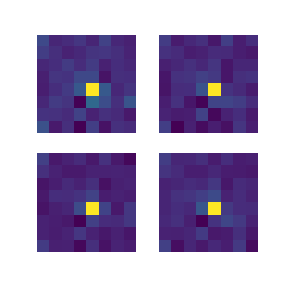

In [ ]:
display_image(100)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
#   image = imageio.imread(filename)
#   writer.append_data(image)
print(type(anim_file))

<class 'str'>


In [ ]:
from IPython.display import HTML

HTML('<img src="./dcgan.gif" />')

In [ ]:
new_images_e = scale_images(X_e_0[:8],(299,299,3))
new_images_samples = scale_images(samples,(299,299,3))
FID(inc_model,new_images_e,new_images_samples)

2.5201194855923252